In [1]:
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os
import glob
from pathlib import Path
import seaborn as sns

kaplan_plots = True
cox_analysis = False

date_time_str = '20230619_192815'
data_path = Path(os.getcwd())

if kaplan_plots:
    kmf = KaplanMeierFitter()

    csv_files = glob.glob(os.path.join(data_path, f"outputs/{date_time_str}/*.csv"))

    if not os.path.exists(f"imgs/{date_time_str}"):
        os.makedirs(f"imgs/{date_time_str}")

    # Group runs by experiment
    grouped_files = {}
    for file in csv_files:
        file_name = os.path.basename(file)
        name_without_suffix = file_name.rsplit("-", 1)[0]
        suffix = file_name.rsplit("-", 1)[1]
        group_key = name_without_suffix

        if group_key not in grouped_files:
            grouped_files[group_key] = []

        grouped_files[group_key].append(file)


    kmfs = {}
    cphs = {}

    # Print the grouped file paths
    for group_key, files in grouped_files.items():
        fig = plt.figure()
        # For computing the mean
        surv_func_ci = pd.DataFrame()
        amt_of_runs = len(files)
        
        mean_survival_plots = pd.DataFrame(columns=list("TE"))
        CPH_data = pd.DataFrame()

        for i, file_path in enumerate(files):
            data_for_CPH = pd.read_csv(file_path)
            
            data_for_CPH_copy = data_for_CPH.copy()
            data_for_CPH_copy.loc[data_for_CPH_copy['T'] == 1000, 'E'] = 0 # post hoc fix if the last timestep is used as time of death
            
            datakf = data_for_CPH_copy[list('TE')]
            
            mean_survival_plots = pd.concat([mean_survival_plots, datakf])
            CPH_data = pd.concat([CPH_data, data_for_CPH_copy])

        kmf = KaplanMeierFitter(label=group_key)
        cphs[group_key] = CPH_data

        kmfs[group_key] = kmf.fit(mean_survival_plots["T"], mean_survival_plots['E']) # Deze line geeft die warnings, maar kon het niet oplossen nog
        kmf.plot(label='Mean')

        plt.suptitle("Kaplan-Meier survival graph", fontsize=18)
        plt.title(group_key, fontsize=10)
        plt.xlabel("Time steps")
        plt.ylabel("Survival probability")
        plt.legend()

        plt.savefig(f"imgs/{date_time_str}/km-{group_key}.png")
        plt.close()


    

c:\Users\freek\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
c:\Users\freek\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
c:\Users\freek\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.

In [10]:
# All combinations image A (for Appendix)
fig = plt.figure(figsize=(10, 10))

legend_ax = fig.add_subplot(111, frameon=False)
legend_ax.axis('off')

nr_agents = [50, 100] # [50, 100, 200, 300]
dists = ['Sides', 'Uniform', 'RandomGrid']
probs = [0.5, 0.8, 1]
i=0

for nr_agent in nr_agents:
    for dist in dists:
        for prob in probs:
            i+=1

            if i == 1:
                ax = plt.subplot(6, 3, i)
            else:
                ax = plt.subplot(6, 3, i, sharex=ax, sharey=ax)

            if dist == 'RandomGrid':
                dist_name = 'Random Blobs'
            else:
                dist_name = dist
            plt.title(f'{dist_name}, nr_agents = {nr_agent}, prob. = {prob}', fontsize=10)
            ax = kmfs[f'Baseline-no_trade-{dist}-{nr_agent}-{prob}'].plot(label='Non-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-random-{dist}-{nr_agent}-{prob}'].plot(label='Random-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-pathfind_neighbor-{dist}-{nr_agent}-{prob}'].plot(label='Neighbor-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Market-pathfind_market-{dist}-{nr_agent}-{prob}'].plot(label='Market-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(handles), bbox_to_anchor=(0.5, 0.94), fontsize=12)
fig.tight_layout(rect=(0.03, 0.03, 1, 0.9))
plt.subplots_adjust(wspace=0.3)
fig.text(0.5, 0.03, 'Time steps', ha='center', va='center', fontsize=14)
fig.text(0.03,  0.5, 'Survival probability', ha='center', va='center', rotation='vertical', fontsize=14)
plt.suptitle("Kaplan-Meier survival graphs (A)", fontsize=20, y=0.98)
plt.savefig(f"imgs/{date_time_str}/kms-comparison-market-uber-A.pdf")
plt.close()


# All combinations image B (for Appendix)
fig = plt.figure(figsize=(10, 10))

legend_ax = fig.add_subplot(111, frameon=False)
legend_ax.axis('off')

nr_agents = [200, 300] # [50, 100, 200, 300]
dists = ['Sides', 'Uniform', 'RandomGrid']
probs = [0.5, 0.8, 1]
i=0

for nr_agent in nr_agents:
    for dist in dists:
        for prob in probs:
            i+=1

            if i == 1:
                ax = plt.subplot(6, 3, i)
            else:
                ax = plt.subplot(6, 3, i, sharex=ax, sharey=ax)
            
            if dist == 'RandomGrid':
                dist_name = 'Random Blobs'
            else:
                dist_name = dist
            plt.title(f'{dist_name}, nr_agents = {nr_agent}, prob. = {prob}', fontsize=10)
            ax = kmfs[f'Baseline-no_trade-{dist}-{nr_agent}-{prob}'].plot(label='Non-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-random-{dist}-{nr_agent}-{prob}'].plot(label='Random-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-pathfind_neighbor-{dist}-{nr_agent}-{prob}'].plot(label='Neighbor-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Market-pathfind_market-{dist}-{nr_agent}-{prob}'].plot(label='Market-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(handles), bbox_to_anchor=(0.5, 0.94), fontsize=12)
fig.tight_layout(rect=(0.03, 0.03, 1, 0.9))
plt.subplots_adjust(wspace=0.3)
fig.text(0.5, 0.03, 'Time steps', ha='center', va='center', fontsize=14)
fig.text(0.03,  0.5, 'Survival probability', ha='center', va='center', rotation='vertical', fontsize=14)
plt.suptitle("Kaplan-Meier survival graphs (B)", fontsize=20, y=0.98)
plt.savefig(f"imgs/{date_time_str}/kms-comparison-market-uber-B.pdf")
plt.close()

C:\Users\freek\AppData\Local\Temp\ipykernel_15452\220188696.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 3, i)
C:\Users\freek\AppData\Local\Temp\ipykernel_15452\220188696.py:64: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 3, i)


# CPH for BLobs

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')
         T    E  Trade_random  Trade_search  Trade_market
0   1000.0  0.0             0             0             0
1   1000.0  0.0             0             0             0
2   1000.0  0.0             0             0             0
3   1000.0  0.0             0             0             0
4    659.0  1.0             0             0             0
..     ...  ...           ...           ...           ...
45   214.0  1.0             0             0             1
46   192.0  1.0             0             0             1
47   555.0  1.0             0             0             1
48   184.0  1.0             0             0             1
49   169.0  1.0             0             0             1

[1000 rows x 5 columns]


<lifelines.CoxPHFitter: fitted with 1000 total observations, 361 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 639
   partial log-likelihood = -4001.42
         time fit was run = 2023-06-21 10:46:00 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.73       0.48       0.12            -0.97            -0.50                 0.38                 0.60
Trade_search   0.90       2.45       0.10             0.71             1.08                 2.03                 2.96
Trade_market   0.90       2.45       0.10             0.71             1.09                 2.04                 2.96

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00 -6.21 <0.005      30.77
Trade_search     0.00  9.39 <0.005      67.14
Trade_market     0.00  9.39 <0.005      67.19
---
Concordance = 0.50
Partial AIC = 8008.85
log-likelihood ratio test = 283.91 on 3 df
-log2(p) of ll-ratio test = 201.04

Summary dataframe:
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
Trade_random -0.734738   0.479631  0.118404       -0.966806       -0.502670   
Trade_search  0.897479   2.453411  0.095602        0.710104        1.084855   
Trade_market  0.898061   2.454839  0.095626        0.710638        1.085484   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                  
Trade_random             0.380296             0.604913     0.0 -6.205337   
Trade_search             2.034202             2.959011     0.0  9.387697   
Trade_market             2.035289             2.960874     0.0  9.391399   

                         p   -log2(p)  
covariate                              
Trade_random  5.457967e-10  30.770917  
Trade_search  6.132617e-21  67.143987  
Trade_market  5.920863e-21  67.194682  


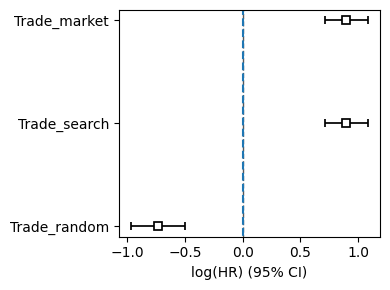

In [3]:
cox_analysis = True

if cox_analysis:
    combined_df = pd.concat([cphs['Baseline-no_trade-RandomGrid-50-0.8'],
                             cphs['Baseline-random-RandomGrid-50-0.8'],
                             cphs['Baseline-pathfind_neighbor-RandomGrid-50-0.8'],
                             cphs['Market-pathfind_market-RandomGrid-50-0.8'],
    ])

    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df)
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-RG-50-0.8-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.print_summary()
    print("Summary dataframe:")
    cph_df = cph.summary
    print(cph_df)
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-RG-50-0.8-results.csv")

    plt.figure(figsize=(4, 3))
    cph.plot()
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.show()

# CPH for Sides

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')
        T    E  Trade_random  Trade_search  Trade_market
0   116.0  1.0             0             0             0
1   122.0  1.0             0             0             0
2   183.0  1.0             0             0             0
3   124.0  1.0             0             0             0
4   139.0  1.0             0             0             0
..    ...  ...           ...           ...           ...
45  166.0  1.0             0             0             1
46  226.0  1.0             0             0             1
47  200.0  1.0             0             0             1
48  116.0  1.0             0             0             1
49  183.0  1.0             0             0             1

[1000 rows x 5 columns]


<lifelines.CoxPHFitter: fitted with 1000 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 1000
   partial log-likelihood = -5835.13
         time fit was run = 2023-06-21 10:46:02 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.07       0.93       0.08            -0.23             0.09                 0.79                 1.10
Trade_search  -0.12       0.89       0.08            -0.28             0.04                 0.76                 1.05
Trade_market  -0.96       0.38       0.09            -1.13            -0.78                 0.32                 0.46

               cmp to      z      p   -log2(p)
covariate                                     
Trade_random     0.00  -0.85   0.40       1.33
Trade_search     0.00  -1.41   0.16       2.67
Trade_market     0.00 -10.85 <0.005      88.66
---
Concordance = 0.50
Partial AIC = 11676.26
log-likelihood ratio test = 153.99 on 3 df
-log2(p) of ll-ratio test = 107.77

Summary dataframe:
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
Trade_random -0.069726   0.932649  0.082406       -0.231239        0.091787   
Trade_search -0.116726   0.889829  0.082498       -0.278419        0.044966   
Trade_market -0.956611   0.384193  0.088186       -1.129452       -0.783770   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to          z  \
covariate                                                                   
Trade_random              0.79355             1.096131     0.0  -0.846129   
Trade_search              0.75698             1.045993     0.0  -1.414903   
Trade_market              0.32321             0.456681     0.0 -10.847655   

                         p   -log2(p)  
covariate                              
Trade_random  3.974808e-01   1.331043  
Trade_search  1.570969e-01   2.670274  
Trade_market  2.046081e-27  88.659195  

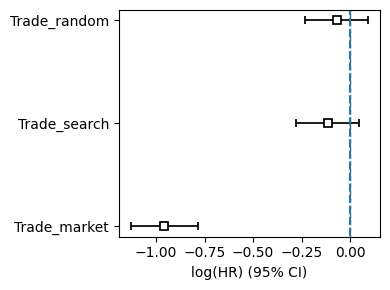

In [4]:



cox_analysis = True

if cox_analysis:
    combined_df = pd.concat([cphs[f'Baseline-no_trade-Sides-50-1'],
                             cphs[f'Baseline-random-Sides-50-1'],
                             cphs[f'Baseline-pathfind_neighbor-Sides-50-1'],
                             cphs[f'Market-pathfind_market-Sides-50-1'],
    ])

    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df)
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.print_summary()
    print("Summary dataframe:")
    cph_df = cph.summary
    print(cph_df)
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-results.csv")

    plt.figure(figsize=(4, 3))
    cph.plot()
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.show()

# CPH Sides threshold of significance market (varying nr agents)

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')


<lifelines.CoxPHFitter: fitted with 1000 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 1000
   partial log-likelihood = -5847.17
         time fit was run = 2023-06-21 10:46:04 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.08       0.93       0.08            -0.24             0.08                 0.79                 1.09
Trade_search   0.04       1.04       0.08            -0.13             0.20                 0.88                 1.22
Trade_market  -0.85       0.43       0.09            -1.02            -0.67                 0.36                 0.51

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00 -0.94   0.35       1.53
Trade_search     0.00  0.43   0.67       0.58
Trade_market     0.00 -9.52 <0.005      69.03
---
Concordance = 0.50
Partial AIC = 11700.33
log-likelihood ratio test = 129.92 on 3 df
-log2(p) of ll-ratio test = 90.52

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')


<lifelines.CoxPHFitter: fitted with 2000 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2000
number of events observed = 2000
   partial log-likelihood = -13144.68
         time fit was run = 2023-06-21 10:46:06 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.14       0.87       0.06            -0.25            -0.03                 0.78                 0.97
Trade_search   0.06       1.06       0.06            -0.06             0.17                 0.94                 1.19
Trade_market  -0.56       0.57       0.06            -0.68            -0.45                 0.51                 0.64

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00 -2.41   0.02       5.96
Trade_search     0.00  0.97   0.33       1.60
Trade_market     0.00 -9.36 <0.005      66.73
---
Concordance = 0.50
Partial AIC = 26295.37
log-likelihood ratio test = 123.68 on 3 df
-log2(p) of ll-ratio test = 86.06

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')


<lifelines.CoxPHFitter: fitted with 4000 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 4000
number of events observed = 4000
   partial log-likelihood = -29117.66
         time fit was run = 2023-06-21 10:46:11 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.06       0.94       0.04            -0.14             0.02                 0.87                 1.02
Trade_search   0.04       1.04       0.04            -0.04             0.12                 0.96                 1.13
Trade_market  -0.39       0.68       0.04            -0.47            -0.31                 0.62                 0.73

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00 -1.52   0.13       2.95
Trade_search     0.00  1.01   0.31       1.68
Trade_market     0.00 -9.42 <0.005      67.60
---
Concordance = 0.50
Partial AIC = 58241.31
log-likelihood ratio test = 127.21 on 3 df
-log2(p) of ll-ratio test = 88.59

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')


<lifelines.CoxPHFitter: fitted with 6000 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 6000
number of events observed = 6000
   partial log-likelihood = -46181.48
         time fit was run = 2023-06-21 10:46:18 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.09       0.91       0.03            -0.16            -0.03                 0.85                 0.97
Trade_search  -0.02       0.98       0.03            -0.08             0.05                 0.92                 1.05
Trade_market  -0.20       0.82       0.03            -0.26            -0.13                 0.77                 0.87

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00 -2.78   0.01       7.53
Trade_search     0.00 -0.56   0.58       0.80
Trade_market     0.00 -5.95 <0.005      28.46
---
Concordance = 0.50
Partial AIC = 92368.95
log-likelihood ratio test = 41.76 on 3 df
-log2(p) of ll-ratio test = 27.73

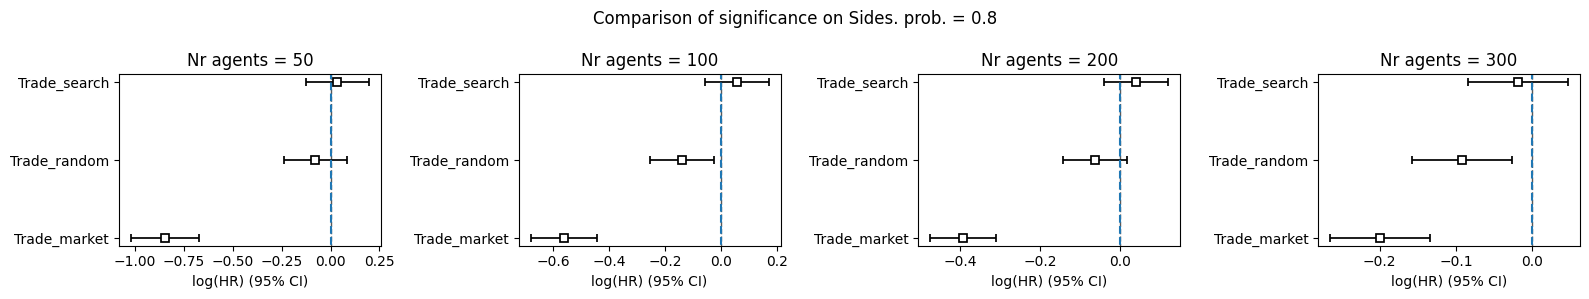

In [5]:
cox_analysis = True

nagentsss = [50, 100, 200, 300]

plt.figure(figsize=(16,3))

for i, n_agents in enumerate(nagentsss):
    if i > 0:
        ax = plt.subplot(1, 4, i+1, sharey=ax)
    else:
        ax = plt.subplot(1, 4, i+1)
    combined_df = pd.concat([cphs[f'Baseline-no_trade-Sides-{n_agents}-0.8'],
                             cphs[f'Baseline-random-Sides-{n_agents}-0.8'],
                             cphs[f'Baseline-pathfind_neighbor-Sides-{n_agents}-0.8'],
                             cphs[f'Market-pathfind_market-Sides-{n_agents}-0.8'],
    ])
    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-{n_agents}-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-{n_agents}-results.csv")
    cph.print_summary()

    cph.plot()
    plt.title(f'Nr agents = {n_agents}')
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.suptitle('Comparison of significance on Sides. prob. = 0.8')
    
plt.show()

# CPH for Uniform

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')
          T    E  Trade_random  Trade_search  Trade_market
0     313.0  1.0             0             0             0
1     281.0  1.0             0             0             0
2    1000.0  0.0             0             0             0
3     317.0  1.0             0             0             0
4     372.0  1.0             0             0             0
..      ...  ...           ...           ...           ...
295   229.0  1.0             0             0             1
296  1000.0  0.0             0             0             1
297   255.0  1.0             0             0             1
298   187.0  1.0             0             0             1
299   312.0  1.0             0             0             1

[6000 rows x 5 columns]

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping 

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 6000 total observations, 1121 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic      p  -log2(p)
Trade_market km              8.80 <0.005      8.37
             rank            7.55   0.01      7.38
Trade_random km              2.60   0.11      3.23
             rank            2.76   0.10      3.37
Trade_search km              1.23   0.27      1.91
             rank            0.91   0.34      1.56



1. Variable 'Trade_market' failed the non-proportional test: p-value is 0.0030.

   Advice: with so few unique values (only 2), you can include `strata=['Trade_market', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



<lifelines.CoxPHFitter: fitted with 6000 total observations, 1121 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 6000
number of events observed = 4879
   partial log-likelihood = -39444.14
         time fit was run = 2023-06-21 10:46:26 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.00       1.00       0.04            -0.07             0.07                 0.93                 1.07
Trade_search  -0.01       0.99       0.04            -0.09             0.06                 0.92                 1.06
Trade_market  -0.08       0.92       0.04            -0.15            -0.01                 0.86                 0.99

               cmp to     z    p   -log2(p)
covariate                                  
Trade_random     0.00 -0.02 0.98       0.03
Trade_search     0.00 -0.42 0.68       0.56
Trade_market     0.00 -2.26 0.02       5.39
---
Concordance = 0.50
Partial AIC = 78894.27
log-likelihood ratio test = 6.31 on 3 df
-log2(p) of ll-ratio test = 3.36

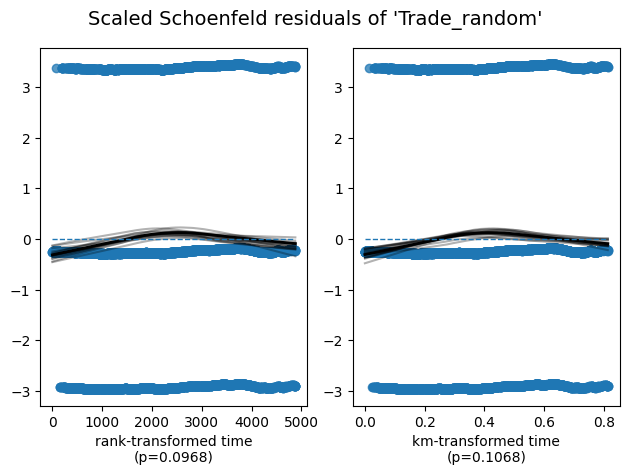

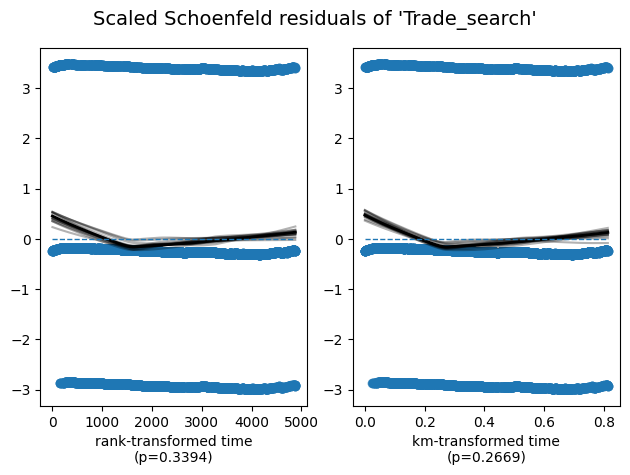

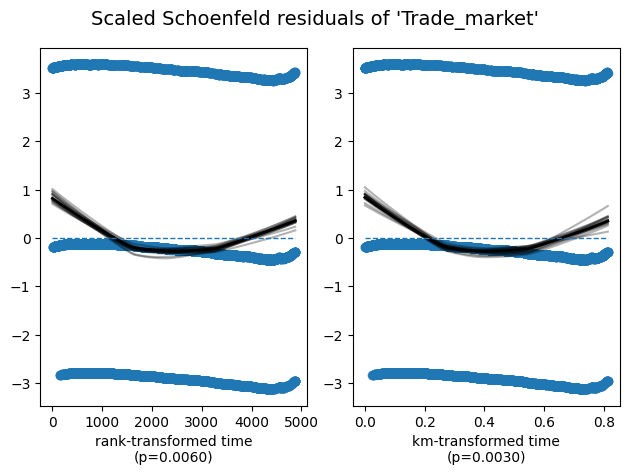

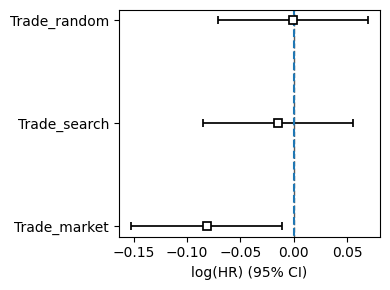

In [6]:
cox_analysis = True

if cox_analysis:
    combined_df = pd.concat([cphs[f'Baseline-no_trade-Uniform-300-0.8'],
                             cphs[f'Baseline-random-Uniform-300-0.8'],
                             cphs[f'Baseline-pathfind_neighbor-Uniform-300-0.8'],
                             cphs[f'Market-pathfind_market-Uniform-300-0.8'],
    ])

    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df)
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.check_assumptions(combined_df.reset_index(drop=True), p_value_threshold=0.05, show_plots=True)


    cph.print_summary()
    cph_df = cph.summary
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-results.csv")

    plt.figure(figsize=(4, 3))
    cph.plot()
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.show()

# CPH for all data

In [17]:
cox_analysis = True

if cox_analysis:
    # Analysis
    def concatAllRuns(data_path: Path):
        csv_files = glob.glob(os.path.join(data_path, f"outputs/{date_time_str}/*.csv"))
        combined_df = pd.concat([pd.read_csv(f) for f in csv_files], axis=0)
        return combined_df
    
    date_time_str = '20230619_192815'
    data_path = Path(os.getcwd())
    combined_df = concatAllRuns(data_path)
    print(combined_df)
    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df.tail())
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-RG-50-0.8-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.print_summary()
    print("Summary dataframe:")
    cph_df = cph.summary
    print(cph_df)
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-results-all.csv")

          T    E  Scenario  Agent_type Distribution  Num_agents  Trading  \
0     242.0  1.0  Baseline    no_trade   RandomGrid       100.0     True   
1    1000.0  1.0  Baseline    no_trade   RandomGrid       100.0     True   
2     577.0  1.0  Baseline    no_trade   RandomGrid       100.0     True   
3    1000.0  1.0  Baseline    no_trade   RandomGrid       100.0     True   
4     137.0  1.0  Baseline    no_trade   RandomGrid       100.0     True   
..      ...  ...       ...         ...          ...         ...      ...   
295     NaN  NaN       NaN         NaN          NaN         NaN      NaN   
296     NaN  NaN       NaN         NaN          NaN         NaN      NaN   
297     NaN  NaN       NaN         NaN          NaN         NaN      NaN   
298     NaN  NaN       NaN         NaN          NaN         NaN      NaN   
299     NaN  NaN       NaN         NaN          NaN         NaN      NaN   

     Move_prob  Run_number       T  ...  Run_number       T    E Scenario  \
0         

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

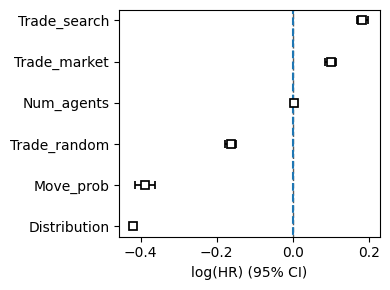

In [8]:
plt.figure(figsize=(4, 3))
cph.plot()
plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
plt.tight_layout()
plt.show()